In [ ]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report)

import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from data.load_data import download_creditcard_data, load_creditcard_df

# Project step 3: Random Forest on credit card fraud detection

In this notebook we implement a Random Forest classifier to detect credit card fraud. We use HalvingRandomSearchCV to tune hyperparameters efficiently - its like a tournament where weak candidates get eliminated early.

Random Forest is basically a bunch of decision trees working together, so it should perform well on this kind of problem.

In [3]:
download_creditcard_data()
df = load_creditcard_df()

# remove duplicates just in case
df = df.drop_duplicates().reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df["Class"].value_counts())
print(f"\nFraud percentage: {df['Class'].mean() * 100:.4f}%")

Dataset shape: (283726, 31)

Class distribution:
Class
0    283253
1       473
Name: count, dtype: int64

Fraud percentage: 0.1667%


In [4]:
# split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# train test split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:")
print(f"  Size: {len(X_train)}")
print(f"  Fraud cases: {y_train.sum()} ({y_train.mean() * 100:.4f}%)")
print(f"\nTest set:")
print(f"  Size: {len(X_test)}")
print(f"  Fraud cases: {y_test.sum()} ({y_test.mean() * 100:.4f}%)")

Train set:
  Size: 226980
  Fraud cases: 378 (0.1665%)

Test set:
  Size: 56746
  Fraud cases: 95 (0.1674%)


In [5]:
# we only scale Time and Amount since the V features are already from PCA
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

## 1. Baseline Random Forest

Lets start with a basic Random Forest to see how it does without any tuning. We use class_weight="balanced" to handle the imbalanced data.

In [6]:
# basic random forest with balanced class weights
baseline_rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=100,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

baseline_rf.fit(X_train, y_train)

y_pred_baseline = baseline_rf.predict(X_test)
y_proba_baseline = baseline_rf.predict_proba(X_test)[:, 1]

print("Baseline Random Forest results:")
print(classification_report(y_test, y_pred_baseline, digits=4))

Baseline Random Forest results:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998     56651
           1     0.9855    0.7158    0.8293        95

    accuracy                         0.9995     56746
   macro avg     0.9925    0.8579    0.9145     56746
weighted avg     0.9995    0.9995    0.9995     56746



## 2. Hyperparameter tuning with HalvingRandomSearchCV

Doing a full grid search or even RandomizedSearchCV with many parameters takes forever on large datasets like ours (226k samples). It was impossible on our personnal GPUs, so we used a smarter approach that is HalvingRandomSearchCV. It uses a technique called "successive halving".

We begin with a lot of parameter choices and test them on a small part of the data.
We keep the ones that work best and remove the others.
Then we use more data and test the remaining candidates again.
We repeat this step each time with more data until we finally get the best model trained on the full dataset.

In [7]:
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # needed to enable it
from sklearn.model_selection import HalvingRandomSearchCV

# pipeline for tuning - note: n_estimators will be controlled by halving search
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

# parameter distributions (no n_estimators - its controlled by the halving resource)
param_distributions = {
    "model__max_depth": [5, 10, 15, 20, None],
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2"],
}

In [8]:
# run halving random search with n_estimators as resource
# this keeps ALL data in every round (important for imbalanced data)
halving_search = HalvingRandomSearchCV(
    estimator=rf_pipe,
    param_distributions=param_distributions,
    resource="model__n_estimators",
    min_resources=20,
    max_resources=100,
    n_candidates=10,
    factor=3,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

halving_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in halving_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 score: {halving_search.best_score_:.4f}")

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters found:
  model__max_depth: 20
  model__max_features: sqrt
  model__min_samples_leaf: 1
  model__min_samples_split: 13
  model__n_estimators: 60

Best CV F1 score: 0.8337


In [9]:
# evaluate best model on test set (directly from halving search)
best_rf = halving_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Random Forest results on test set:")
print(classification_report(y_test, y_pred_best, digits=4))

Tuned Random Forest results on test set:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9452    0.7263    0.8214        95

    accuracy                         0.9995     56746
   macro avg     0.9724    0.8631    0.9106     56746
weighted avg     0.9995    0.9995    0.9994     56746



## 3. Comparison: baseline vs tuned model

Lets see how much the tuning helped.

In [10]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

results = []
results.append(compute_metrics(y_test, y_pred_baseline, y_proba_baseline, "RF Baseline"))
results.append(compute_metrics(y_test, y_pred_best, y_proba_best, "RF Tuned"))

results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,RF Baseline,0.999507,0.985507,0.715789,0.829268,0.935110
1,RF Tuned,0.999471,0.945205,0.726316,0.821429,0.928489


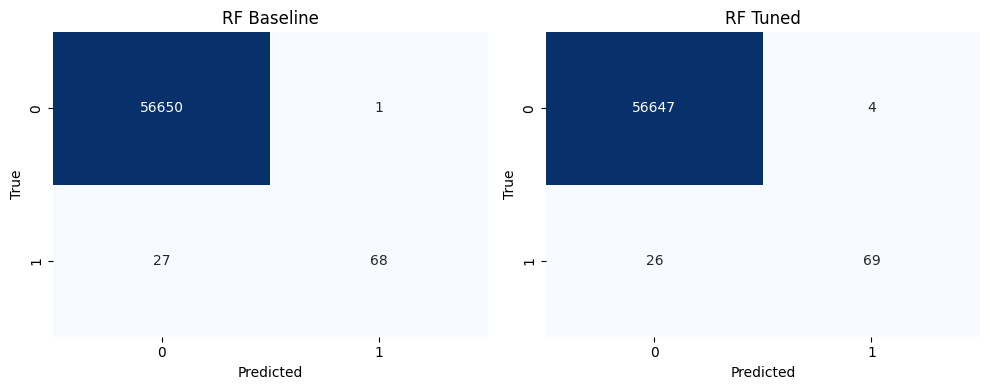

In [11]:
# plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

models_preds = {
    "RF Baseline": y_pred_baseline,
    "RF Tuned": y_pred_best,
}

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

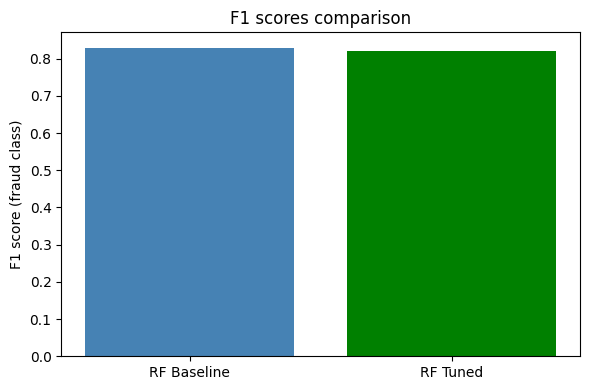

In [12]:
# bar plot of F1 scores
plt.figure(figsize=(6, 4))
plt.bar(results_df["model"], results_df["f1"], color=["steelblue", "green"])
plt.ylabel("F1 score (fraud class)")
plt.title("F1 scores comparison")
plt.tight_layout()
plt.show()

We attempted hyperparameter tuning with RandomizedSearchCV/HalvingRandomSearchCV but the baseline Random Forest with default parameters and class_weight='balanced' performed better. This suggests the default sklearn parameters are already well-optimized for this type of problem

## 4. Feature importance

One great thing about Random Forest is we can see which features matter most. Lets check it

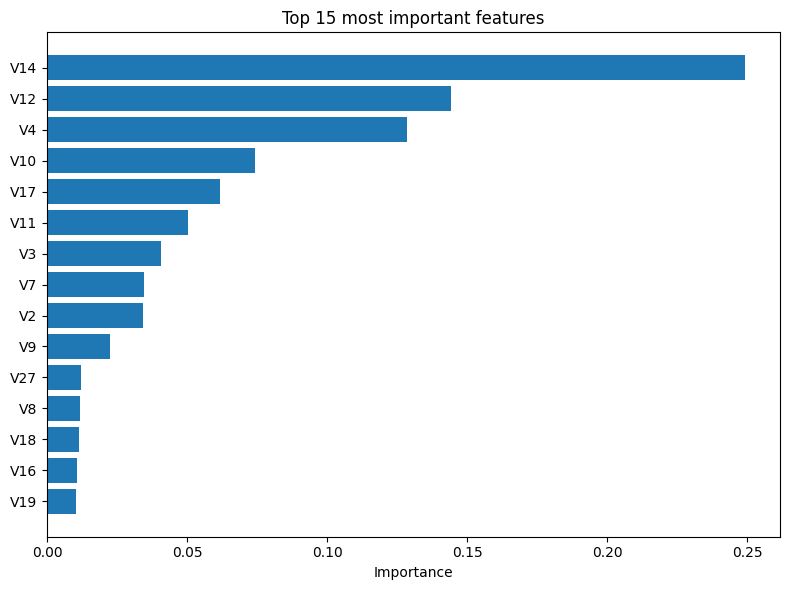

In [13]:
# get feature importances from the tuned model
rf_model = best_rf.named_steps["model"]
importances = rf_model.feature_importances_

# get feature names after preprocessing
feature_names = numeric_to_scale + other_features

# create dataframe and sort
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# plot top 15 features
plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"][:15][::-1], importance_df["importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 most important features")
plt.tight_layout()
plt.show()

In [14]:
# print top 10 features
print("Top 10 most important features:")
print(importance_df.head(10).to_string(index=False))

Top 10 most important features:
feature  importance
    V14    0.249143
    V12    0.144326
     V4    0.128370
    V10    0.074072
    V17    0.061800
    V11    0.050348
     V3    0.040661
     V7    0.034557
     V2    0.034262
     V9    0.022350


## 5. Conclusion

In this notebook we implemented a Random Forest classifier for credit card fraud detection. The baseline model with default parameters and class_weight="balanced" achieved strong results right away, with an F1 score of 0.83 on the fraud class.

We explored hyperparameter tuning using HalvingRandomSearchCV, which works like a tournament: many parameter combinations start on small data samples, and weak performers get eliminated early before investing more compute time. However, the tuned model did not outperform the baseline. This is actually common with Random Forest since sklearn default parameters are already well-optimized, and the class_weight="balanced" parameter effectively handles the imbalanced data.

If we just look at feature importance, the most influential features for fraud detection are V14, V12 and V4, which are principal components from the original PCA transformation.